# Decomposition of the Hopfield Network created by the MRP
GOAL: understand what going on step by step

Here they created two separate Hopfield Network, one for the track reconstruction in the odd modules and one for the track reconstruction in the even modules.

Fonctions "imbriquées" 

---------- 1 -----------

> run "save_experiment" fct
>> run "evaluate_events" fct
>>> run "load_events" fct
>>> run "Hopfield" class (twice: even and odd, then group results)

---------- 2 -----------
> "prepare_instance" fct: looks like it could be used to test the network (and create kind of false generated instance) but not use in the rest of the code (only at the very very end but not necesseraly used), so I'll not used it here
> "load_instance" fct : same

## 1. Modules needed

In [2]:
############################### DEPENDENCIES ##################################
import json
import os
import sys
import contextlib
import io
import numpy as np
import inspect
import os.path
import matplotlib.pyplot as plt
from math import pi, atan, sin, sqrt, tanh, cosh, exp, ceil
import seaborn as sns
from numpy.core.fromnumeric import shape
import random
import time
import math
import statistics
from pathlib import Path

## 2. File path

In [3]:
filename = inspect.getframeinfo(inspect.currentframe()).filename
file_path = os.path.dirname(os.path.abspath(filename))
project_root = os.path.dirname(file_path)

if project_root not in sys.path:
    sys.path.append(project_root)

from event_model import event_model as em
from validator import validator_lite as vl
import data_analysis.event_generator as eg
from visual.color_map import Colormap

print(project_root)

c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub


## 3. Context manager and helper

In [4]:
########################### CONTEXTS ##################################
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

In [5]:
########################### HELPER FUNCTIONS ##################################
def get_polar_coordinates(x, y):
    r = math.sqrt(x ** 2 + y ** 2)
    phi = math.atan2(x, y)
    if phi < 0:
        phi = math.pi - phi
    return r, phi

## 4. Functions about the events (dealing with the data/preparing them/plot them)

### load_event fct

In [6]:
def load_event(file_name, plot_event=False):
    f = open(file_name)
    json_data_event = json.loads(f.read())

    ev = em.event(json_data_event, read_tracks=True)

    modules = ev.modules
    tracks = ev.real_tracks

    if plot_event:
        eg.plot_tracks_and_modules(tracks, modules, title="Loaded Event")

    modules_even = []
    modules_odd = []

    for i in range(len(modules)):
        if i % 2 == 0:
            modules_even.append(modules[i])
        else:
            modules_odd.append(modules[i])

    return json_data_event, modules_even, modules_odd, tracks, modules

In [7]:
i = 2
event_file_name = "/datasets/minibias/velo_event_"
file_name = project_root + event_file_name
print(file_name)

c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/minibias/velo_event_


In [8]:
json_data_event, modules_even, modules_odd, tracks, modules = load_event(file_name + str(i) + ".json", plot_event=False)

## 5. Save_experiment fct

In [16]:
def save_experiment(exp_name, exp_num, desc, p, event_file_name, nr_events):
    f = open(project_root + "/algorithms/experiments/" + exp_name + ".txt", "a")
    f.write(
        f"\nExperiment {exp_num}\n\n{desc}\nNumber of events: {nr_events}\nParameters: {p}\n"
    )
    f.close()
    evaluate_events(
        project_root + event_file_name,
        p,
        nr_events,
        True,
        project_root + "/algorithms/experiments/" + exp_name + ".txt",
    )
    f = open(project_root + "/algorithms/experiments/" + exp_name + ".txt", "a")


> Parameters: 
- exp_name: name of the file where we save the experiment
- exp_num : small description/number to identify the experiment
- desc : large description to identify and explain the experiment
- p : parameters used to run the evaluate_events fct 
- event_file_name: name of the file where the events to evaluate are (minibias or bshphiphi)
- nr_events: number of events to be processed by the evalute_events fct

> Explanation:
1. Open a file at a specified location with the file name being 'exp_name + ".txt" in append mode in which we'll save the results of the experiments.

2. Write a string containing the experiment number, description, number of events and the parameters of the experiment into the file.

3. Close the file.

4. Call another function evaluate_events with these arguments: the file location, parameters, number of events, whether to plot the event (a boolean value) and the location of the file opened in step 1.

5. Reopen the same file as in step 1 in append mode.   

! NB: the output file is specified through the parameters of the 'evalute_events' function

## 6. Evaluate_events fct

In [17]:
def evaluate_events(file_name, parameters, nr_events=1, plot_event=False, output_file=None):

    json_data_all_events = []
    all_tracks = []
    iter_even = 1
    iter_odd = 1

    all_events = [i for i in range(995)]
    random.seed(40)
    random.shuffle(all_events)
    count = 0
    j = 0
    
    while count < nr_events:
        i = all_events[j]
        j += 1
        print("[INFO] Evaluate Event: %s" % file_name + str(i))
        size = os.path.getsize(file_name + str(i) + ".json")
        json_data_event, modules = load_event(
            file_name + str(i) + ".json", plot_event=False
        )
        max_neurons = 0
        last = 0
        for m in modules[0]:
            n_hits = len(m.hits())
            if last * n_hits > max_neurons:
                max_neurons = last * n_hits
            last = n_hits
        last = 0
        for m in modules[1]:
            n_hits = len(m.hits())
            if last * n_hits > max_neurons:
                max_neurons = last * n_hits
            last = n_hits
        if max_neurons > 2200:
            continue

        print(f"\nstarting instance {count} out of {nr_events}\n")
        start_time = time.time()
        even_hopfield = Hopfield(modules=modules[0], parameters=parameters)
        odd_hopfield = Hopfield(modules=modules[1], parameters=parameters)
        end_time = time.time() - start_time
        print(
            "[INFO] Hopfield Networks initialized in %i mins %.2f seconds"
            % (end_time // 60, end_time % 60)
        )

        try:
            iter_even = even_hopfield.bootstrap_converge(
                bootstraps=parameters["bootstrap_iters"],
                method=parameters["bootstrap_method"],
            )
            iter_odd = odd_hopfield.bootstrap_converge(
                bootstraps=parameters["bootstrap_iters"],
                method=parameters["bootstrap_method"],
            )

            start_time = time.time()
            even_hopfield.mark_bifurcation()
            odd_hopfield.mark_bifurcation()
            even_tracks = even_hopfield.full_tracks()
            odd_tracks = odd_hopfield.full_tracks()
            event_tracks = even_tracks + odd_tracks
            end_time = time.time() - start_time
            print(
                "[INFO] tracks extracted in %i mins %.2f seconds"
                % (end_time // 60, end_time % 60)
            )

            json_data_all_events.append(json_data_event)
            all_tracks.append(event_tracks)

            if plot_event:
                even_hopfield.plot_network_results()
                odd_hopfield.plot_network_results()

            count = count + 1
        except:
            continue

    start_time = time.time()
    if output_file:
        print(output_file)
        sys.stdout = open(output_file, "a")
        print(f"Average number of iterations per convergence: {(iter_even+iter_odd)/2}")
        vl.validate_print(json_data_all_events, all_tracks, return_data=True)
        print("____________________")
        sys.stdout.close()
        sys.stdout = sys.__stdout__
    end_time = time.time() - start_time

    # we could check how many tracks acutally cross the detector sides i guess to identify where some clones come from...
    print(
        "[INFO] validation excecuted in %i mins %.2f seconds"
        % (end_time // 60, end_time % 60)
    )



NB: this function is run by the 'save_experiment' function
> Parameters:
- file_name: name of the file where the events to evaluate are (minibias or bshphiphi)
- parameters: parameters used in the simulation
- nr_events: number of events to be processed (default is 1)
- plot_event: whether to plot the events (default is False)
- output_file: file to write output to (default is None) 

> Explanation:
1. Load the required libraries and define the function evaluate_events with parameters.

2. Initialize variables to store event data and the result of the simulation

3. Create a list of all events and shuffle it randomly with seed 40

4. For each event:

- Print the event name
- Load the event data from file using load_event function (!)
- Check if the event meets a condition (max_neurons <= 2200), if not, continue to the next event
- Initialize the Hopfield networks for the event with the given parameters, one for each type of modules (odd and even) > Need to see the Hopfield part
- Try to bootstrap the Hopfield networks and mark bifurcation
- Obtain the final track ("full_tracks()") for both networks and group them together in one network
- Extract the real tracks of the event from the json data 
- Store the Hopfield tracks and the real tracks for the event
- Plot the results if plot_event is True (two separate graphs)
- Increment the count of processed events
- Write the results to the output file if specified
- Print the time it took to validate the events

## 7. Hopfield class

### Event example

In [9]:
i = 504
event_file_name = "/datasets/minibias/velo_event_"
file_name = project_root + event_file_name
print(file_name)

c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/minibias/velo_event_


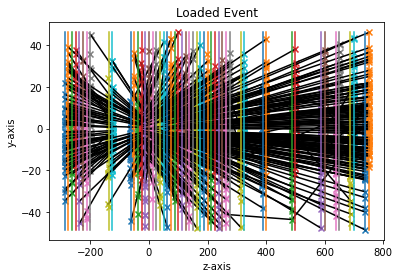

In [10]:
json_data_event, modules_even, modules_odd, tracks, modules = load_event(file_name + str(i) + ".json", plot_event=True)

### Functions about Network initialization

In [12]:
parameters = {
        ### NEURONS ###
        "random_neuron_init": True,
        "binary_states": False,  # try it out once maybe but scrap it
        ### WEIGHTS ###
        "ALPHA": 1,
        "BETA": 10,
        "GAMMA": 10,
        "narrowness": 200,
        "constant_factor": 0.9,
        "monotone_constant_factor": 0.9,
        #### UPDATE ###
        "T": 1e-8,  # try to experiment with these rather
        "B": 1e-4,  # try to experiment with these rather
        "T_decay": lambda t: max(1e-8, t * 0.01),  # try to remove these
        "B_decay": lambda t: max(1e-4, t * 0.04),  # try to remove these
        "decay_off": False,  # using this
        "randomized_updates": True,
        "fully_randomized_updates": False,
        #### THRESHOLD ###
        "maxActivation": True,
        "THRESHOLD": 0.2,
        ##### CONVERGENCE ###
        "convergence_threshold": 0.00000005,
        "bootstrap_iters": 10,
        "bootstrap_method": "below_mean",
        ###### BIFURC REMOVAL #####
        "smart": True,
        "only_weight": False,
        "max_activation": False,
        ###### Track prunning #######
        # here we could set the threshold
        "pruning_tr": 0.01,
    }

In [13]:
p = parameters
m = modules
start_T = p["T"]
start_B = p["B"]
N = None
N_info = None
modules_count = len(modules)
hit_counts = [len(module.hits()) for module in m]
neuron_count = [
    hit_counts[i] * hit_counts[i + 1]
    for i in range(modules_count - 1)
    ]
flips = 0
max_neurons = max(neuron_count)
#init_neurons(tracks=tracks)
#init_weights()
extracted_hits = set()
extracted_tracks = []
extracted_track_states = []
energies = []



> Quick analysis:
- module_count = number modules implicated in the event
- hit_counts = list containing the number of hits by modules in the event
- neuron_count = list that stores the count of neurons for each layer in the network
- max_neurons = number max of neurons in the layers of the network 

In [14]:
print('Modules count:', modules_count,'\n')

print('Hit counts:', hit_counts)
print('Len of hit counts:', len(hit_counts),'\n')

print('Neuron count:', neuron_count)
print('Len of neuron count:',len(neuron_count),'\n')

print('# of neurons max:',max_neurons)


Modules count: 52 

Hit counts: [41, 61, 37, 56, 36, 54, 39, 56, 45, 55, 49, 35, 54, 65, 60, 55, 55, 59, 61, 70, 56, 58, 60, 60, 63, 65, 75, 64, 72, 67, 67, 66, 72, 67, 77, 72, 81, 74, 80, 70, 83, 69, 80, 65, 78, 62, 81, 65, 88, 68, 87, 69]
Len of hit counts: 52 

Neuron count: [2501, 2257, 2072, 2016, 1944, 2106, 2184, 2520, 2475, 2695, 1715, 1890, 3510, 3900, 3300, 3025, 3245, 3599, 4270, 3920, 3248, 3480, 3600, 3780, 4095, 4875, 4800, 4608, 4824, 4489, 4422, 4752, 4824, 5159, 5544, 5832, 5994, 5920, 5600, 5810, 5727, 5520, 5200, 5070, 4836, 5022, 5265, 5720, 5984, 5916, 6003]
Len of neuron count: 51 

# of neurons max: 6003


In [15]:
def init_neurons(tracks: list = None):
        # consider hits inbetween 2 modules as one neuron layer
        # the neurons in N are ordered h(1,1)-h(2,1); h(1,1)-h(2,2); h(1,1)-h(2,3) etc
        
        if p["random_neuron_init"]:
            N = np.random.uniform(size=(modules_count - 1, max_neurons))
        else:
            N = np.ones(shape=(modules_count - 1, max_neurons))

        if tracks:
            N = np.zeros(shape=(modules_count - 1, max_neurons))
            
        for idx, nc in enumerate(neuron_count):  
            #idx is a simple index from 0 to 34 (neuron_count is 35)
            #nc is the value of neuronns count for that index ex: [0,1], [1,3], ..., [34,20] 
            # > in layer 0, we have 1 neurons, in layer 2, we have 3 neurons
            N[idx, nc:] = 0
            # this  sets the value of N matrix to zero for elements after neuron_count[idx] in each row idx of N, 
            # effectively limiting the number of neurons in each layer to the corresponding value in neuron_count[idx].


        N_info = np.zeros(shape=(modules_count - 1, max_neurons, 4))
        
        for idx in range(modules_count - 1):
            m1 = m[idx]       #first module i
            m2 = m[idx + 1]   #second module i+1

            for i, hit1 in enumerate(m1.hits()):
                for j, hit2 in enumerate(m2.hits()):
                    # crossing all hits i in module 1 with all hits j in module 2

                    n_idx = i * hit_counts[idx + 1] + j 
                    
                    if tracks:
                        for t in tracks:
                            if hit1 in t and hit2 in t:
                                N[idx, n_idx] = 1 #activate the neuron
                                
                    # maybe we can check these angles again
                    angle_xz = atan((hit2.x - hit1.x) / (hit2.z - hit1.z))
                    angle_yz = atan((hit2.y - hit1.y) / (hit2.z - hit1.z))
                    norm_dist = sqrt(
                        (hit2.y - hit1.y) ** 2 + (hit2.x - hit1.x) ** 2
                    ) / sqrt(
                        (hit2.z - hit1.z) ** 2
                    )  

                    _, r_hit1 = get_polar_coordinates(hit1.x, hit1.y)
                    _, r_hit2 = get_polar_coordinates(hit2.x, hit2.y)
                    monotone_dist = (r_hit2 - r_hit1) / (hit2.z - hit1.z)

                    N_info[idx, n_idx, 0] = abs(angle_xz)
                    N_info[idx, n_idx, 1] = abs(angle_yz)
                    N_info[idx, n_idx, 2] = norm_dist  
                    N_info[idx, n_idx, 3] = monotone_dist

In [16]:
N = np.random.uniform(size=(modules_count - 1, max_neurons))

for idx, nc in enumerate(neuron_count):  
            #idx is a simple index from 0 to 34 (neuron_count is 35)
            #nc is the value of neuronns count for that index ex: [0,1], [1,3], ..., [34,20] 
            # > in layer 0, we have 1 neurons, in layer 2, we have 3 neurons
            N[idx, nc:] = 0
print(shape(N))


(51, 6003)


In [17]:
N_info = np.zeros(shape=(modules_count - 1, max_neurons, 4))
        
for idx in range(modules_count - 1):
            m1 = m[idx]       #first module i
            m2 = m[idx + 1]   #second module i+1

            for i, hit1 in enumerate(m1.hits()):
                for j, hit2 in enumerate(m2.hits()):
                    # crossing all hits i in module 1 with all hits j in module 2

                    n_idx = i * hit_counts[idx + 1] + j 
                    
                    if tracks:
                        for t in tracks:
                            if hit1 in t and hit2 in t:
                                N[idx, n_idx] = 1 #activate the neuron
                                
                    # maybe we can check these angles again
                    angle_xz = atan((hit2.x - hit1.x) / (hit2.z - hit1.z))
                    angle_yz = atan((hit2.y - hit1.y) / (hit2.z - hit1.z))
                    norm_dist = sqrt(
                        (hit2.y - hit1.y) ** 2 + (hit2.x - hit1.x) ** 2
                    ) / sqrt(
                        (hit2.z - hit1.z) ** 2
                    )  

                    _, r_hit1 = get_polar_coordinates(hit1.x, hit1.y)
                    _, r_hit2 = get_polar_coordinates(hit2.x, hit2.y)
                    monotone_dist = (r_hit2 - r_hit1) / (hit2.z - hit1.z)

                    N_info[idx, n_idx, 0] = abs(angle_xz)
                    N_info[idx, n_idx, 1] = abs(angle_yz)
                    N_info[idx, n_idx, 2] = norm_dist  
                    N_info[idx, n_idx, 3] = monotone_dist

In [18]:
print(shape(N))
print(shape(N_info))

(51, 6003)
(51, 6003, 4)


Neurons initialization:
> Parameters:
- tracks: list of tracks with default value as None

> Explanation:
1. Initializes the values of the 'N' matrix either randomly or with ones depending on the value of p["random_neuron_init"].

2. If tracks is not None, then sets the values of N matrix to zeros.

3. Sets the values of N matrix to zeros for elements after neuron_count[idx] for each index idx in neuron_count.

5. Initializes the values of the N_info matrix to zeros (this effectively limit the number of neurons in each layer to the corresponding value in neuron_count[idx])

6. Loops over each pair of consecutive modules in m and their corresponding hits in m1.hits() and m2.hits:().
- If tracks is not None, sets the value of the current neuron to 1 if both hits are present in the same track.
- Calculates the angles between the hit pair in the xz and yz plane.
- Calculates the Euclidean distance between the hit pair, normalized by the distance between the hits in the z direction.
- Calculates the monotonic distance between the hit pair in polar coordinates.
- Assigns the calculated values to the appropriate position in the N_info matrix.


In [53]:
def init_weights(neg_weights=False):

        ### Get parameters from the dictionnary p
        alpha = p["ALPHA"]
        beta = p["BETA"]
        gamma = p["GAMMA"]

        #### Creation of the weights matrix empty
        W = np.zeros(shape=(modules_count - 2, max_neurons, max_neurons)) 

        ### Filling of weights
        for w_idx in range(modules_count - 2):  #This loop iterates w_idx over the indices of the modules, excluding the first and last modules.
            
            for con_idx in range(hit_counts[w_idx + 1]):  # This loop iterates con_idx over the indices of the hits in the current module.
                
                for i in range(hit_counts[w_idx]):  # m1
                    ln_idx = i * hit_counts[w_idx + 1] + con_idx  # left_neuron_idx
                    
                    for j in range(hit_counts[w_idx + 2]):  # m3
                        rn_idx = ( con_idx * hit_counts[w_idx + 2] + j)  # right_neuron_idx

                        # Constant term from the other group
                        constant = (N_info[w_idx, ln_idx, 2] - N_info[w_idx + 1, rn_idx, 2])
                        constant = tanh(constant) * (p["narrowness"] + 1) # tanh to force between -1 and 1
                        constant = (-2 * constant ** 2) + 1  # this should be high if both terms are similar and low/penalizing if both are not similar
                        constant = constant * p["constant_factor"]
                        constant = min(max(constant, - p["constant_factor"]),p["constant_factor"])

                        # monotone constant
                        monotone_constant = (N_info[w_idx, ln_idx, 3]- N_info[w_idx + 1, rn_idx, 3])
                        monotone_constant = tanh(monotone_constant) * (p["narrowness"] + 1)  # tanh to force between -1 and 1
                        monotone_constant = ( -2 * monotone_constant ** 2) + 1  # this should be high if both terms are similar and low/penalizing if both are not similar
                        monotone_constant = (monotone_constant * p["monotone_constant_factor"])
                        monotone_constant = min(max(monotone_constant, - p["monotone_constant_factor"]),p["monotone_constant_factor"],)

                        theta = abs(
                            N_info[w_idx, ln_idx, 0]
                            - N_info[w_idx + 1, rn_idx, 0]
                        )

                        phi = abs(
                            N_info[w_idx, ln_idx, 1]
                            - N_info[w_idx + 1, rn_idx, 1]
                        )

                        W[w_idx, ln_idx, rn_idx] = (
                            alpha
                            * ((1 - sin(theta)) ** beta)
                            * ((1 - sin(phi)) ** gamma)
                            + monotone_constant
                            + constant
                        )
                        #    + constant # this does not work properly

                        if not neg_weights:
                            W[w_idx, ln_idx, rn_idx] = max(
                                0, W[w_idx, ln_idx, rn_idx]
                            )
                        # maybe we can play a bit around with this



Initialization of the weight matrix 'W':

> Parameters:
- neg_weights: boolean parameter, which determines whether the weights should be positive or not.

> Explanation: compute the weights between pairs of neurons in the different layers (i.e. the segments weights)
1. Retrieve alpha, beta, and gamma from a dictionary p corresponding to the parameters. These values are used in the computation of the weights.

2. Initialize the weight matrix W of shape (modules_count - 2, max_neurons, max_neurons,) by computing weights between pairs of neurons in the different layers. 

3. Loop through each layer of neurons (from w_idx in range(modules_count - 2)), w_idx = "module ID" and then loop through the different module (neuron layers) of the network to calculate the weights of each connection (segments) between the neurons in adjacent layers of the network (m1,m2,m3). The weights are based on 4 factors: theta, phi, constant, and monotone constant.

- Theta and phi are the differences in orientation between the neurons of adjacent layers, calculated as the absolute difference between the N_info values of the two neurons in the 0th and 1st columns, respectively.
- Constant and monotone constant are penalizing terms, calculated as a tanh function applied to the difference between the N_info values of the two neurons in the 2nd and 3rd columns, respectively. The results are squared, transformed to range from -1 to 1, and multiplied by constant_factor and monotone_constant_factor, respectively.
- The final weight of the connection between two neurons is calculated as the product of the orientation terms (theta and phi) and the two constant terms, raised to a power of beta and gamma, respectively, and then scaled by alpha.
- The final weight is stored in the W matrix, with dimensions (modules_count-2) x (hit_counts[w_idx]) x (hit_counts[w_idx + 2]), where w_idx is the index of the module connecting the two neuron layers, hit_counts[w_idx] is the number of neurons in the left layer, and hit_counts[w_idx + 2] is the number of neurons in the right layer



In [31]:
neg_weights=False

alpha = p["ALPHA"]
beta = p["BETA"]
gamma = p["GAMMA"]
        #####################################
W = np.zeros(shape=(modules_count - 2, max_neurons, max_neurons))

for w_idx in range(modules_count - 2): # from 0 to 36: for each neurons layer (- the first one)
                                       # w_idx = module ID
    for con_idx in range(hit_counts[w_idx + 1]):          #m2, 'for all hits in module 2'
        
        for i in range(hit_counts[w_idx]):                #m1, 'for all hits in module 1'
            ln_idx = i * hit_counts[w_idx + 1] + con_idx                # left_neuron_idx

            for j in range(hit_counts[w_idx + 2]):        #m3, 'for all hits in module 3'
                        rn_idx = (con_idx * hit_counts[w_idx + 2] + j)   # right_neuron_idx

                        # Constant term from the other group
                        constant = (N_info[w_idx, ln_idx, 2] - N_info[w_idx + 1, rn_idx, 2])
                        constant = tanh(constant) * (p["narrowness"] + 1)  # tanh to force between -1 and 1
                        constant = (-2 * constant ** 2) + 1  # this should be high if both terms are similar and low/penalizing if both are not similar
                        constant = constant * p["constant_factor"]
                        constant = min(max(constant, - p["constant_factor"]),p["constant_factor"])

                        # Monotone constant
                        monotone_constant = (N_info[w_idx, ln_idx, 3]- N_info[w_idx + 1, rn_idx, 3])
                        monotone_constant = tanh(monotone_constant) * (p["narrowness"] + 1)  # tanh to force between -1 and 1
                        monotone_constant = (-2 * monotone_constant ** 2) + 1  # this should be high if both terms are similar and low/penalizing if both are not similar
                        monotone_constant = (monotone_constant * p["monotone_constant_factor"])
                        monotone_constant = min(max(monotone_constant, - p["monotone_constant_factor"]),p["monotone_constant_factor"])

                        theta = abs(N_info[w_idx, ln_idx, 0] - N_info[w_idx + 1, rn_idx, 0])

                        phi = abs(N_info[w_idx, ln_idx, 1] - N_info[w_idx + 1, rn_idx, 1])

                        W[w_idx, ln_idx, rn_idx] = (
                            alpha
                            * ((1 - sin(theta)) ** beta)
                            * ((1 - sin(phi)) ** gamma)
                            + monotone_constant
                            + constant
                        )
                        #    + constant # this does not work properly

                        if not neg_weights:
                            W[w_idx, ln_idx, rn_idx] = max(
                                0, W[w_idx, ln_idx, rn_idx]
                            )


(50, 6003, 6003)


In [34]:
nonzero_indices = np.nonzero(W)

(50, 6003, 6003)
3
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [38]:
print(W.shape)
print(nonzero_indices)

(50, 6003, 6003)
(array([ 0,  0,  0, ..., 49, 49, 49], dtype=int64), array([  75,   77,   88, ..., 5667, 5672, 5703], dtype=int64), array([ 520,  594, 1007, ...,  862, 1209, 3324], dtype=int64))


### Functions about neurons updating
The "update functions" are used to modify the N matrix containing the state of the neurons. (not the weight matrix !)

In [50]:
def update_neuron_1(idx, i):
        b = p["B"]
        t = p["T"]
        c1 = hit_counts[idx]
        c2 = hit_counts[idx + 1]
        update = 0
        
        ### PART 1 ###

        if idx > 0:  
            update += N[idx - 1, :].T @ W[idx - 1, :, i]

        if idx < modules_count - 2: 
            update += W[idx, i, :] @ N[idx + 1, :]
            
        if 0 < idx < modules_count - 1: 
            update /= 2


        ### PART 2 ###
        # left module and right module hit id -> current neuron connects hit lm_id with hit rn_id
        lm_id = i // c2
        rm_id = i % c2
        # there can be a lot improved runtime wise with storing the sums and adj
        # but too complicated for now
        # all segments mapping to the hit in m1 -> the left module
        m1h = np.sum(N[idx, lm_id * c2 : (lm_id + 1) * c2])
        # all segments mapping to the hit in m2 - the right module
        m2h = np.sum(
            N[idx, : c1 * c2].reshape(c2, c1)[rm_id, :]
        )  # correct as well...
        # we need to subtract the neuron of the segment 2 times because we add it 2 times
        pen = m1h + m2h - 2 * N[idx, i]
        _update = 0.5 * (1 + tanh(update / t - b * pen / t))

        if p["binary_states"]:
            # XXX some threshold... -> we dont use binay states
            if random.random() < _update:
                N[idx, i] = 1
            else:
                N[idx, i] = 0
        else:
            N[idx, i] = _update

In [51]:
def update_neuron_2(idx, i):
        b = p["B"]
        t = p["T"]
        c1 = hit_counts[idx]
        c2 = hit_counts[idx + 1]
        update = 0
        
        ### PART 1 ###

        if idx > 0:  
            update += np.dot(N[idx - 1, :].T, W[idx - 1, :, i])

        if idx < modules_count - 2: 
            update += np.dot(W[idx, i, :], N[idx + 1, :])
            
        if 0 < idx < modules_count - 1: 
            update /= 2


        ### PART 2 ###
        # left module and right module hit id -> current neuron connects hit lm_id with hit rn_id
        lm_id = i // c2
        rm_id = i % c2
        # there can be a lot improved runtime wise with storing the sums and adj
        # but too complicated for now
        # all segments mapping to the hit in m1 -> the left module
        m1h = np.sum(N[idx, lm_id * c2 : (lm_id + 1) * c2])
        # all segments mapping to the hit in m2 - the right module
        m2h = np.sum(
            N[idx, : c1 * c2].reshape(c2, c1)[rm_id, :]
        )  # correct as well...
        # we need to subtract the neuron of the segment 2 times because we add it 2 times
        pen = m1h + m2h - 2 * N[idx, i]
        _update = 0.5 * (1 + tanh(update / t - b * pen / t))

        if p["binary_states"]:
            # XXX some threshold... -> we dont use binay states
            if random.random() < _update:
                N[idx, i] = 1
            else:
                N[idx, i] = 0
        else:
            N[idx, i] = _update

In [95]:
idx = 5     #can go from 0 to 37, module number
i = 0       #hit number (in this particular module)

b = p["B"]
t = p["T"]
c1 = hit_counts[idx]  #list containing the number of hits for module idx in the event
print(c1)
c2 = hit_counts[idx + 1] #list containing the number of hits for module idx+1 in the event
print(c2)
update = 0

### PART 1

#check if it is not the first layer, so applied on all neurons but the first
if idx > 0:             
    update += N[idx - 1, :].T @ W[idx - 1, :, i]  #update based on the weights of the previous module, the module 'before' (idx-1)


# check if it is not the two last layer, so applied on all neurons but the last two
if idx < modules_count - 2:        
    update += W[idx, i, :] @ N[idx + 1, :]   #update based on the weights of this module (idx)

# check if it is not the first layer or the last one,
if 0 < idx < modules_count - 1: 
    update /= 2      

print(update)


3
3
1.375795754050786


> Test with (5,0): The value of update is the same when part 1 and/or two are runnning, then it is divided by 2 after "activation" of the part 3.

In [96]:

### PART 2
lm_id = i // c2  #floor division returning the largest integer less than or equal to the result of the division.
rm_id = i % c2   #module operation returning the remainder of the division of the first operand by the second operand.

print('lm_id:',lm_id)
print('rm_id:',rm_id)


# there can be a lot improved runtime wise with storing the sums and adj
# but too complicated for now

# all segments mapping to the hit in m1 -> the left module
m1h = np.sum(N[idx, lm_id * c2 : (lm_id + 1) * c2])
print('m1h:',m1h)

# all segments mapping to the hit in m2 -> the right module
m2h = np.sum(N[idx, : c1 * c2].reshape(c2, c1)[rm_id, :])  # correct as well...
print('m2h:',m2h)

# we need to subtract the neuron of the segment 2 times because we add it 2 times
pen = m1h + m2h - 2 * N[idx, i]
print('Pen:',pen)

_update = 0.5 * (1 + tanh(update / t - b * pen / t))
print('_update:',_update)

if p["binary_states"]:
            # XXX some threshold... -> we dont use binay states
            if random.random() < _update:
                N[idx, i] = 1
            else:
                N[idx, i] = 0
else:
            N[idx, i] = _update

lm_id: 0
rm_id: 0
m1h: 1.8995181172997566
m2h: 1.8995181172997566
Pen: 1.7990362345995132
_update: 1.0


In [97]:
#idx = list(range(39))
#count = len(idx)
#print(count)

#check if it is not the first layer (but could be the last), so applied on all neurons but the first
#test1=  [x for x in idx if x >0]  
#print(test1)

# check if it is not the last layer (but could be the first), so applied on all neurons but the last
#test2= [x for x in idx if x < count-2]
#print(test2)

# check if it is not the first layer or the last one,
#test3 = [x for x in idx if 0 < x < count-1]
#print(test3)

#=> FROM 1 to 36: all transformations
#=> 0: second transformation 
#=> 38: first transformation
#=> 37: first and last transformation -----> WHY ??????

# For me, it was logic to have 0 and 38 with only one transformation and to divide the rest by 2 as they had two transformation but the 37 is no

NB: this function is only run inside of the update() function (see previously)

Function update_neurons: used to update the weight of a neuron

> Parameters:
- idx: module number/identifiant involved in the event
- i: hit number/identifiant involved in the corresponding module

> Explanation:

PART 1

1. Initialize variables:
- B from a dictionary parameters
- T from the dictionary parameters  
- c1 is an element of the list hit_counts at index idx
- c2 is an element of the list hit_counts at index idx + 1
- update is a variable initialized to 0 that will be used to store the update of the neuron's state

2. Check if the current neuron idx is not the first or the last neuron, if so, update the variable update:
- If idx is not 0, the update is updated with the dot product of the transpose of a slice of the N matrix and a slice of the W tensor.
- If idx is not modules_count - 2, the update is updated with the dot product of a slice of the W tensor and a slice of the N matrix.
- If 0 < idx < modules_count - 1, update is divided by 2.

PART 2

3. The current neuron we're working on (idx,i) connects hit lm_id with hit rn_id
- Calculate the left module and right module indices lm_id and rm_id based on i and c2.  !!! NB !!! this step does not make any sens for me ...
- Calculate m1h as the sum of all segments of the N matrix that map to the hit in the left module.
- Calculate m2h as the sum of all segments of the N matrix that map to the hit in the right module.
- Calculate pen as the sum of m1h and m2h minus 2 times the value of the current neuron N[idx, i].

4. Calculate the update of the neuron state using _update = 0.5 * (1 + tanh(update / t - b * pen / t)).

5. Check the value of the binary_states key in the dictionary p and if binary_states is True: The state of the neuron is updated to either 0 or 1 based on a random number generated using random.random() and compared to _update.

6. If binary_states is False (always false apparently), the state of the neuron is updated to _update.

7. The updated state of the neuron is stored in the N matrix at N[idx, i].


In [52]:
def update1():
    update_list = []
    for idx in range(modules_count - 1): # for each neuron layer
        c1 = hit_counts[idx]             # number of hits in module 1
        c2 = hit_counts[idx + 1]         # number of hits in module 2
        for i in range(c1 * c2):         # number of neurons created between these two module, in this layer
            update_list.append((idx, i)) # create a list of tuples with the idx of the module, and an 'id'
                                         # for the hit, so we'll have by module a number of tuples equals 
                                         # to the number of hits in this module.hits

    if p["randomized_updates"]:
        random.shuffle(update_list)

    if p["fully_randomized_updates"]:
        for c in range(len(update_list)):
            idx, i = random.sample(update_list, 1)[0]
            update_neuron_1(idx, i)

    else:
        for idx, i in update_list:
            update_neuron_1(idx, i)

In [53]:
def update2():
    update_list = []
    for idx in range(modules_count - 1): # for each neuron layer
        c1 = hit_counts[idx]             # number of hits in module 1
        c2 = hit_counts[idx + 1]         # number of hits in module 2
        for i in range(c1 * c2):         # number of neurons created between these two module, in this layer
            update_list.append((idx, i)) # create a list of tuples with the idx of the module, and an 'id'
                                         # for the hit, so we'll have by module a number of tuples equals 
                                         # to the number of hits in this module.hits

    if p["randomized_updates"]:
        random.shuffle(update_list)

    if p["fully_randomized_updates"]:
        for c in range(len(update_list)):
            idx, i = random.sample(update_list, 1)[0]
            update_neuron_2(idx, i)

    else:
        for idx, i in update_list:
            update_neuron_2(idx, i)

In [54]:
update1()

In [55]:
update2()

In [ ]:

update_list = []
for idx in range(modules_count - 1): # for each neuron layer
#for idx in range(1):
    c1 = hit_counts[idx]             # number of hits in module 1
    c2 = hit_counts[idx + 1]         # number of hits in module 2
    for i in range(c1 * c2):         # number of neurons created between these two module (len(c1*c2))=38
        update_list.append((idx, i))

    # We obtain a list of tuple of the form '(idx,i)' where idx in the module number and i is the hit "id", 
    # so if we have 3 hits on the module number 5, we will obtain an update_list containg this:
    #(4, 0), (4, 1), (4, 2),

print(len(update_list))

Function update()
> Parameters: nothing clearly specificied but it uses: modules_count and hit_counts from the starting code.

> Explanation:
1. Initialize an empty list called update_list.
2. Loop over the range(modules_count - 1), and extract two consecutive elements c1 and c2 from the hit_counts list for each module.
3. Within the second loop, a nested loop is run over the range c1 * c2, and for each iteration, a tuple of (idx, i) is appended to the update_list. It creates a list of tuple of the form '(idx,i)' where idx in the module number and i is the hit "id", so if we have 3 hits on the module number 5, we will obtain an update_list containg this (4, 0), (4, 1), (4, 2) for example.

4. If the value of p["randomized_updates"] is True, the elements of the update_list are shuffled using random.shuffle
5. If the value of p["fully_randomized_updates"] is True, a loop is run over the range of the length of the update_list, and for each iteration, a random sample of size 1 is taken from update_list and stored as a tuple (idx, i). Then, update_neuron is called with the idx and i as arguments.
6. If the value of p["fully_randomized_updates"] is False, a loop is run over the update_list, and for each iteration, the update_neuron is called with the tuple elements (idx, i) as arguments.

### Functions about network energy and convergence


In [98]:
def energy():
        b = p["B"]
        E = 0
        bifurc_pen = 0
        for idx in range(modules_count - 2):
            c1 = hit_counts[idx]
            c2 = hit_counts[idx + 1]
            c3 = hit_counts[idx + 2]

            # XXX: just realised we are counting most penalties too often!! -> fixed
            f1 = 0.5
            f2 = 0.5
            if idx == 0:
                f1 = 1
            if idx == modules_count - 3:
                f2 = 1
            N1_pen = N[idx, : c1 * c2].reshape(c2, c1)
            N2_pen = N[idx + 1, : c2 * c3].reshape(c2, c3)
            bifurc_pen = (
                np.sum(np.trace(N1_pen @ N1_pen.T)) * f1
                + np.sum(np.trace(N2_pen @ N2_pen.T)) * f2
                - np.sum(N[idx, :] * N[idx, :]) * f1
                - np.sum(N[idx + 1, :] * N[idx + 1, :]) * f2
            )

            E += (
                -0.5 * (N[idx, :].T @ W[idx, :, :] @ N[idx + 1, :])
                + b * bifurc_pen
            )
        return E

Energy() function: compute the total energy of the network

NB: Only run inside of converge()

> Parameters: 

> Explanation:
1. Initialize variables:
- B from the the dictionary parameters
- E defined to be 0, which will keep track of the total energy
- bifurc_pen defined to be 0, which will keep track of the bifurcation penalty.

2. For loop iterates over idx in the range from 0 to 'modules_count - 2' where modules_count is the number of modules in the system and hit_counts is a list that stores the hit counts. Then within the loop:
- ...
- ...
-
- The function returns E after the loop has finished, which is the total energy of the system.


In [99]:
b = p["B"]
E = 0
bifurc_pen = 0

for idx in range(modules_count - 2):
    c1 = hit_counts[idx]     #m1
    c2 = hit_counts[idx + 1] #m2
    c3 = hit_counts[idx + 2] #m3

    f1 = 0.5
    f2 = 0.5

    if idx == 0: # first module
        f1 = 1
    if idx == modules_count - 3: #last module considered
        f2 = 1

    #Shaping of the matrices N1_pen and N2_pen 
    N1_pen = N[idx, : c1 * c2].reshape(c2, c1)          #penalty between module 1 and 2
    N2_pen = N[idx + 1, : c2 * c3].reshape(c2, c3)      #penalty between module 2 and 3

    bifurc_pen = (
                np.sum(np.trace(N1_pen @ N1_pen.T)) * f1
                + np.sum(np.trace(N2_pen @ N2_pen.T)) * f2
                - np.sum(N[idx, :] * N[idx, :]) * f1
                - np.sum(N[idx + 1, :] * N[idx + 1, :]) * f2
            )
            
    E += ( -0.5 * (N[idx, :].T @ W[idx, :, :] @ N[idx + 1, :]) + b * bifurc_pen ) 

print(E)

-4.29891874768928


In [100]:
def converge():
        # Basically keep updating until the difference in Energy between timesteps is lower than 0.0005 (Based on Stimfple-Abele)
        # Passaleva uses a different kind of convergence i think (4)
        energies = [
            energy()
        ]  # store all energies (not fastest but maybe nice for visualisations)
        t = 0  # timesteps
        p["T"] = start_T
        # self.p["B"] = self.start_B
        # print(f"N at iteration{t}:", np.round(my_instance.N, 1))
        update()
        t += 1
        energies.append(energy())
        while (
            abs(abs(energies[-2]) - abs(energies[-1]))
            >= p["convergence_threshold"]
        ):
            update()
            energies.append(energy())
            # print(f"N at iteration{t}:", np.round(my_instance.N, 1))
            t += 1
            if not p["decay_off"]:
                p["T"] = p["T_decay"](p["T"])
                p["B"] = p["B_decay"](t)
            else:
                pass  # keep T and B fixed

        # print("Network Converged after " + str(t) + " steps")
        # print("Energy = " + str(self.energies[-1]))
        return N, energies[-1], t

Function converge(): simulation of a physical process that starts with initial conditions, runs updates and returns the final state when the difference between energies in consecutive updates is lower than a certain threshold

NB: run energy() and update() functions

> Parameters:

> Explanation:
1. Initialize 'energies', a list that stores all energy values calculated at each iteration, and 't',a counter that counts the number of iterations (timesteps).

2. Set the initial temperature p["T"] to the starting temperature start_T.

3. Call the update function once and increment the t counter.

4. Call the energy function and append the result to the energies list.

5. Check if the absolute difference between the absolute values of the latest two energy values is lower than p["convergence_threshold"]. If it is, the simulation has converged, so the function will return the final state N, the final energy energies[-1], and the number of iterations t. If it hasn't converged, the function will run the update function again, and the energy function to calculate the new energy value, which is appended to the energies list.

6. If p["decay_off"] is False, the temperature p["T"] and a parameter p["B"] are updated using the p["T_decay"] and p["B_decay"] functions, respectively. If p["decay_off"] is True, the temperature and the parameter remain unchanged.

7. Repeat steps 5 and 6 until the simulation has converged.

8. Return N (i.e. matrix with the neurons states), energies[-1] (the energy for the last state of the network), and t once the simulation has converged.

In [101]:
def bootstrap_converge(bootstraps=50, method="mean"):
        start_time = time.time()
        states_list = []
        energy_list = []
        iter_list = []

        for i in range(bootstraps):

            if p["random_neuron_init"]:
                # We only need to reinitialize if we randomly initialize
                init_neurons()

            states, energy, iters = converge()
            print("energy: " + str(energy))

            states_list.append(states)
            energy_list.append(energy)
            iter_list.append(iters)
            # print(f"Finished {i+1}/{bootstraps} iterations")

        if method == "minimum":
            # eventually we could take the lowest 20% or so
            N = states_list[np.argmax(energy_list)]
            energy_list = [np.amax(energy_list)]

        elif method == "below_median":
            median = np.median(energy_list)
            _tmp_states = []
            for states, e in zip(states_list, energy_list):
                if e <= median:
                    _tmp_states.append(states)
            _tmp_states = np.stack(_tmp_states, axis=2)
            N = np.mean(_tmp_states, axis=2)

        elif method == "below_mean":
            mean = np.mean(energy_list)
            _tmp_states = []
            for states, e in zip(states_list, energy_list):
                if e <= mean:
                    _tmp_states.append(states)
            _tmp_states = np.stack(_tmp_states, axis=2)
            N = np.mean(_tmp_states, axis=2)
            
        else:
            stacked_states = np.stack(states_list, axis=2)
            N = np.mean(stacked_states, axis=2)



        end_time = time.time() - start_time
        print(
            "[HOPFIELD] converged network by %s after %i mins %.2f seconds; (energy: %.2f)"
            % (method, end_time // 60, end_time % 60, np.mean(energy_list))
        )
        return sum(iter_list) / len(iter_list)


Function bootstrap_converge(): performs a bootstrap analysis of this optimization problem and returns the average number of iterations needed to converge across the bootstrapped samples.

NB: run the converge() function

> Parameters:
- bootstraps:  number of bootstrals samples 
- method: boostrapping method used

> Explanation:
1. Initialize the start time and empty lists to store the states, energy, and iteration values for each bootstrapped sample.

2. Loop over bootstraps number of times:

- If the p["random_neuron_init"] flag is set to True, it reinitializes the neurons.

- Call the converge function, which performs the optimization and returns the states, energy, and number of iterations.

- Store the returned states, energy, and iteration values in their respective lists.


3. Based on the value of the method argument, it takes the average of the states across all bootstrapped samples in one of the following ways:

- a. If method is set to "minimum", it takes the state with the maximum energy value.

- b. If method is set to "below_median", it takes the average of the states whose energy is below the median energy value.

- c. If method is set to "below_mean", it takes the average of the states whose energy is below the mean energy value.

- d. If method is set to any other value, it takes the average of all states.

4. Calculates the end time and prints the method used, the time taken to converge, and the mean energy value.

5. Returns the average number of iterations across all bootstrapped samples.

### Functions about obtaining the final tracks

In [102]:
def tracks():
# What the papers say:  The answer is given by the final set of active Neurons.
# Idea: All sets of Neurons connected together are considered as track candidates.
# Code idea: All neurons that share a hit and are both connected are track candidates.
    global_candidates = []
    global_candidate_states = []

    for idx in range(modules_count - 2): #for each layer of the network
            candidates = []
            candidate_states = []
            
            l1 = hit_counts[idx]     # number of hits in module 1
            l2 = hit_counts[idx + 1] # number of hits in module 2
            l3 = hit_counts[idx + 2] # number of hits in module 3

            if p["maxActivation"]:
                candidates = []
                thresh = p["THRESHOLD"]

                n1_transform = N[idx, : l2 * l1].reshape(l1, l2).T.copy()       # Reshape and transpose the N matrix containing the state of the neurons for segments between module 1 and module 2
                n2_transform = N[idx + 1, : l3 * l2].reshape(l2, l3).T.copy()   # Reshape and transpose the N matrix containing the state of the neurons for segments between module 2 and module 3
                
                for con in range(l2):  # loop over the connection hits in module 2
                    
                    h1_idx = np.argmax(n1_transform[con, :]) #index of the maximum element of the conth row of n1_transform
                    h3_idx = np.argmax(n2_transform[:, con]) #index of the maximum element of the conth column of n2_transform

                    if (n1_transform[con, h1_idx] < thresh or n2_transform[h3_idx, con] < thresh): 
                        continue #skip this if the value are too low

                    hit1 = m[idx].hits()[h1_idx]
                    hit2 = m[idx + 1].hits()[con]
                    hit3 = m[idx + 2].hits()[h3_idx]

                    candidates.append(em.track([hit1, hit2, hit3]))
                    extracted_hits.add(hit1)
                    extracted_hits.add(hit2)
                    extracted_hits.add(hit3)

                    # if we get the same state
                    candidate_states.append(n1_transform[con, h1_idx])
                    candidate_states.append(n2_transform[h3_idx, con])

                    # XXX
                    # this prevents the display of bifurcation?!
                    #n1_transform[
                    #    :, h1_idx
                    # ] = 0  # set this hit to 0 so it's not chosen again
                    #n2_transform[h3_idx, :] = 0

            global_candidates += candidates
            global_candidate_states += candidate_states

    extracted_tracks = global_candidates
    extracted_track_states = global_candidate_states

    return global_candidates


Function tracks(): extract tracks from a set of neurons.

NB1: I think here we just obtain a bunch of seeds (of 3 hits) and then in the next function we'll decide how to select the best ones

NB2: This function is run inside of full_tracks() function.

> Parameters:

> Explanation:
1. Initialize two empty lists, global_candidates and global_candidate_states, to store the extracted tracks and the corresponding states respectively.

2. Loop over the layers from the first to the last using for idx in range(self.modules_count - 2).

3. In each iteration of the loop, two more empty lists candidates and candidate_states are initialized to store the extracted tracks and the corresponding states respectively for the current iteration. l1, l2 and l3 are defined as the number of hits in module 1, module 2, and module 3 respectively.

5. If p["maxActivation"] is set to True, the code proceeds to extract tracks. Thresh is defined as p["THRESHOLD"] from the dictionnary parameters.

6. n1_transform and n2_transform are defined as the transpose of reshaped matrices.

- c. The code then loops over the connection hits in module 2, for con in range(l2)'.

- d. In each iteration of the inner loop, h1_idx is defined as the index of the maximum element of the conth row of n1_transform, and h3_idx is defined as the index of the maximum element of the conth column of n2_transform.

- e.The code then checks if the values of n1_transform[con, h1_idx] and n2_transform[h3_idx, con] are less than thresh, and if they are, the inner loop continues to the next iteration.

- f. If n1_transform[con, h1_idx] and n2_transform[h3_idx, con] are not less than thresh, the code then defines hit1, hit2, and hit3 as the corresponding hits in the three modules and appends the list of these hits as a track in candidates. The code then adds these three hits to the set extracted_hits. The values of n1_transform[con, h1_idx] and n2_transform[h3_idx, con] are then added to candidate_states.

- g. Finally, global_candidates and global_candidate_states are updated with the values of candidates and candidate_states respectively.

6. After the loop is completed, extracted_tracks and extracted_track_states are defined as global_candidates and global_candidate_states respectively, and the function returns global_candidates.



In [103]:
def prune_tracks(tracks, track_infos):
        tr = p["pruning_tr"]
        out_tracks = []
        
        for track, info in zip(tracks, track_infos): #for each track candidates
            num_hits = len(track) #total number of hits by tracks
            if num_hits < 3:      #clear out the tracks that are too small
                continue
            cand = [track[0], track[1]]
            cand_info = info[0]

            for idx in range(1, num_hits - 1):
                if sum(abs(cand_info - info[idx])) < tr:
                    cand = cand + [track[idx + 1]]
                else:
                    if len(cand) > 2:
                        out_tracks = out_tracks + [cand]
                    cand = [track[idx], track[idx + 1]]
                cand_info = info[idx]

            if len(cand) > 2:
                out_tracks = out_tracks + [cand]
                
        return out_tracks #NB: out_tracks = tracks kept in the final solution


Function prune_tracks(): processes each track and associated track information and prunes the tracks to return a list of relevant tracks

NB: this function is only run inside of full_tracks() function.

> Parameters:
- tracks: tracks created inside of the function full_tracks()
- track_info: information about track created inside of the function full_tracks()

> Explanation:
1. Initialize two variables out_tracks as an empty list and tr from the value of p["pruning_tr"].  

2. For each track and its associated track information in zip(tracks, track_infos):
3. Get the total number of hits in the track.
4. If num_hits is less than 3, the track is not relevant, and the loop continues to the next track.
5. Create a temporary list cand containing the first two elements of the current track, and a variable cand_info with the first information tuple.
6. For each index from 1 to num_hits-1:
- If the sum of absolute differences between cand_info and the current information tuple is less than tr, add the next element of the current track to cand.
- If the sum of absolute differences is greater than or equal to tr, and cand has more than 2 elements, add cand to out_tracks and reset cand to a list containing only the current and next elements of the track.
- If cand has more than 2 elements, add it to out_tracks.

3. Return out_tracks.

In [104]:
def full_tracks():
        # this will deal with stange angles!!!
        # under the assumption that we removed bifuration completely
        # init this active tracks with all active neurons in layer 1! -> key is the right hit

        global_candidates = []
        global_candidate_states = []
        global_candidate_info = []
        tracks = {}
 
        # Operates in two nested loops over the number of modules and number of hits in each module.
        for idx in range(modules_count - 1):
            tracks_2 = {}
            l1 = hit_counts[idx]      # number of hits in module 1 / Left module
            l2 = hit_counts[idx + 1]  # number of hits in module 2 / Right module

            tr = p["THRESHOLD"]

            for segment in range(l1 * l2):

                if N[idx, segment] < tr:    # neurons states matrix
                    continue                # if the value of the state is too low, then don't even consider this segment

                r_hit = m[idx + 1].hits()[segment % l2] 
                l_hit = m[idx].hits()[segment // l2]
                #> confused about this but look the same as inside of the function update_neurons() 
                #> it work wellto create all combinations of hits inbetween the two modules so all segments possible

                ### IF CONTINUING A TRACK ####
                if l_hit in tracks.keys():  #useful once the function has already loop several times

                    (track, states, angle) = tracks[l_hit] #info retrieved from the 'previous track'

                    track = track + [r_hit]                  #add the right hit to the track (a the left hit is already in it)
                    states = states + [N[idx, segment]]      #add the state of this segment to the track states
                    info = angle + [N_info[idx, segment, :]] #add the info of this segment to the track info
                    del tracks[l_hit]                        #because we already have this information previously in all 3 variables

                    extracted_hits.add(r_hit)
                    tracks_2[r_hit] = (track, states, info)
                
                ### IF STARTING A NEW TRACK ####
                else:
                    track = [l_hit, r_hit]            #create a new track with the left and right hits
                    states = [N[idx, segment]]        #create a new state with the current state segment
                    info = [N_info[idx, segment, :]]  #create a new angle information with the current segment

                    tracks_2[r_hit] = (track, states, info) #add the right hit to the tracks_2 dictionnary with the new informations
                    extracted_hits.add(r_hit)               #add the right hit to the extracted hits set
                    extracted_hits.add(l_hit)               #add the right hit to the extracted hits set

            for _, value in tracks.items():  #inner loop for each layer
                (track, states, info) = value
                global_candidates = global_candidates + [track]
                global_candidate_states = global_candidate_states + [states]
                global_candidate_info = global_candidate_info + [info]
            tracks = tracks_2  # updates the tracks dictionary to be the tracks_2 dictionary.

        for _, value in tracks.items():      #outer loop in total
            (track, states, info) = value
            global_candidates = global_candidates + [track]
            global_candidate_states = global_candidate_states + [states]
            global_candidate_info = global_candidate_info + [info]

        # here comes the function of 'pruning...' maybe i need to store more info for doing that!!!
        global_candidates = prune_tracks(global_candidates, global_candidate_info)

        global_candidates = [em.track(hits) for hits in global_candidates]
        extracted_tracks = global_candidates
        extracted_track_states = global_candidate_states # ??????? there is a problem here no? because these states are not the ones of the pruned global candidate

        return global_candidates

    # tr 0.1 seems decent for sum of info differences...

In [105]:
global_candidates = []
global_candidate_states = []
global_candidate_info = []
tracks = {}

# Operates in two nested loops over the number of modules and number of hits in each module.
for idx in range(modules_count - 1):
    tracks_2 = {}
    l1 = hit_counts[idx]      # number of hits in module 1 / Left module        ex: 3 hits
    l2 = hit_counts[idx + 1]  # number of hits in module 2 / Right module       ex: 2 hits
    tr = p["THRESHOLD"]

    #print('module:' ,idx, '\n\n')

    for segment in range(l1 * l2): #> ex: 3*2 (indeed, 6 possibles segments), so for each possible segment ... !!! NB: a segment is a neuron ...
        if N[idx, segment] < tr:
        #    print('NO \n')    # value for this neuron/segment in the neurons states matrix, 
            continue                # if the value of the state is too low, then don't even consider this segment
        
        #print('segment:',segment,',l1:',l1, ',l2:',l2 )
        #print('left:',segment // l2)
        #print('right:',segment % l2)

        l_hit = m[idx].hits()[segment // l2]
        r_hit = m[idx + 1].hits()[segment % l2] 
        #print('Hits:',l_hit, r_hit,'\n')
                
        if l_hit in tracks.keys():  #useful once the function has already loop several times, check if the left hit is already in the track dictionary,
            #as we start the track from left to right, the right hit of the track i could become the left hit of the track i+1

                    (track, states, angle) = tracks[l_hit] #info retrieved from the 'previous track'

                    track = track + [r_hit]
                    states = states + [N[idx, segment]]
                    info = angle + [N_info[idx, segment, :]]

                    del tracks[l_hit]

                    extracted_hits.add(r_hit)
                    tracks_2[r_hit] = (track, states, info)

        else: # the left hit is not already used in a segment before
                    track = [l_hit, r_hit]
                    states = [N[idx, segment]]
                    info = [N_info[idx, segment, :]]

                    tracks_2[r_hit] = (track, states, info)
                    extracted_hits.add(r_hit)
                    extracted_hits.add(l_hit)
        
    for _, value in tracks.items():
        (track, states, info) = value
        global_candidates = global_candidates + [track]
        global_candidate_states = global_candidate_states + [states]
        global_candidate_info = global_candidate_info + [info]
    tracks = tracks_2

for _, value in tracks.items():
    (track, states, info) = value
    global_candidates = global_candidates + [track]
    global_candidate_states = global_candidate_states + [states]
    global_candidate_info = global_candidate_info + [info]

# here comes the function of 'pruning...' maybe i need to store more info for doing that!!!

global_candidates = prune_tracks(global_candidates, global_candidate_info)

global_candidates = [em.track(hits) for hits in global_candidates]
extracted_tracks = global_candidates
extracted_track_states = global_candidate_states

print(global_candidates)



[]


full_tracks(): creates a list of tracks by pairing hits in sequential modules of a particle detector.

 NB: run tracks() and prune_tracks() functions

 > General idea: 
 
 It operates in two nested loops over the number of modules (modules_count) and number of hits in each module. For each hit in the first module, it checks for a match with a hit in the next module. If a match is found, a track is created with the two hits and stored in a dictionary (tracks) where the key is the hit in the first module.






In [ ]:
def mark_bifurcation(self):
        zero = True
        max_activation = self.p["max_activation"]
        smart = self.p["smart"]

        if max_activation:
            zero = False
        if smart:
            zero = False
            max_activation = False

        tr = self.p["THRESHOLD"]

        N[N <= tr] = 0 #states of the neurons = 0 if the initial state is below the treshold

        # search for bifurcation neurons
        for idx in range(self.modules_count - 1): #for each layer
            #Idea:
            # 1. we visit all neurons in one layer and check for neurons where the activation is bigger than tr
            # 2. we check all adjacent neurons for activation and check how many are higher than the treshold
            # 3. for each segment we look wether there is bifurcation on the left or right hit

            c1 = self.hit_counts[idx]
            c2 = self.hit_counts[idx + 1]

            for segment in range(c1 * c2): #for each neuron/segment

                if self.N[idx, segment] < tr:
                    continue

                r_hit = segment % c2
                l_hit = segment // c2

                # left-right bifurcation
                activation_mask = self.N[idx, : c1 * c2].reshape(c1, c2)[:, r_hit] > tr

                if sum(activation_mask) > 1:  # we have bifuct into the right hit
                    affected_neurons = []
                    for i in range(c1):  # loop over all nerons affected by bifurc
                        if activation_mask[i]:
                            # well here are the bifurcation things detected. here we would need to come up with a smart way to resolve it
                            if zero:
                                self.N[idx, (i * c2) + r_hit] = 0
                            else:
                                affected_neurons = affected_neurons + [(i * c2) + r_hit]
                    if smart:
                        # simple rule -> when bifurc is detected on right side -> we look next active neurons going out
                        # and promote the ones where the weight is high... (angle diff is low)
                        # if next neuron layer exist!!!
                        if idx < self.modules_count - 2:  # can check to the right
                            c3 = self.hit_counts[idx + 2]
                            activation_mask_2 = (
                                self.N[idx + 1, : c2 * c3].reshape(c2, c3)[r_hit, :]
                                > tr
                            )
                            affected_neurons_2 = []
                            for i in range(
                                c3
                            ):  # loop over all nerons affected by bifurc
                                if activation_mask_2[i]:
                                    affected_neurons_2 = affected_neurons_2 + [
                                        c3 * r_hit + i
                                    ]
                            if len(affected_neurons_2) > 0:
                                max_val = 0
                                max_l = None
                                max_r = None
                                for e in affected_neurons:
                                    for j in affected_neurons_2:
                                        c = (
                                            self.N[idx, e]
                                            * self.W[idx, e, j]
                                            * self.N[idx + 1, j]
                                        )
                                        if self.p["only_weight"]:
                                            c = self.W[idx, e, j]
                                        if c > max_val:
                                            max_l = e
                                            max_r = j
                                            max_val = c
                                    self.N[idx, e] = 0
                                for j in affected_neurons_2:
                                    self.N[idx + 1, j] = 0
                                if max_r is not None and max_l is not None:
                                    self.N[idx, max_l] = 1
                                    self.N[idx + 1, max_r] = 1
                            else:
                                max_activation = True
                        else:
                            max_activation = True

                    if max_activation:
                        max_activation = self.N[idx, affected_neurons[0]]
                        max_id = affected_neurons[0]
                        for e in affected_neurons:
                            if self.N[idx, e] >= max_activation:
                                max_id = e
                                max_activation = self.N[idx, e]

                            self.N[idx, e] = 0

                        self.N[idx, max_id] = 1
                    if smart:
                        max_activation = False

                # right-left bifurcation
                activation_mask = self.N[idx, : c1 * c2].reshape(c1, c2)[l_hit, :] > tr
                if sum(activation_mask) > 1:
                    affected_neurons = []
                    affected_neurons_2 = []
                    for i in range(c2):
                        if activation_mask[i]:
                            if zero:
                                self.N[idx, (l_hit * c2) + i] = 0
                            else:
                                affected_neurons = affected_neurons + [(l_hit * c2) + i]
                    if smart:  # i know there can be only one neuron on the right.
                        if idx > 0:
                            # can check here only for the first active neuron, because we removed
                            # the other bifurcation in the previous iteration
                            c0 = self.hit_counts[idx - 1]
                            activation_mask_2 = (
                                self.N[idx - 1, : c0 * c1].reshape(c0, c1)[:, l_hit]
                                > tr
                            )
                            if sum(activation_mask_2) > 0:
                                for i in range(
                                    c0  # this was c0...
                                ):  # loop over all nerons affected by bifurc
                                    if activation_mask_2[i]:
                                        affected_neurons_2 = affected_neurons_2 + [
                                            c1 * i + l_hit
                                        ]

                                if len(affected_neurons_2) > 0:
                                    max_val = 0
                                    max_l = None
                                    max_r = None
                                    for e in affected_neurons_2:
                                        for j in affected_neurons:
                                            c = (
                                                self.N[idx - 1, e]
                                                * self.W[idx - 1, e, j]
                                                * self.N[idx, j]
                                            )
                                            if self.p["only_weight"]:
                                                c = self.W[idx - 1, e, j]
                                            if c > max_val:
                                                max_l = e
                                                max_r = j
                                                max_val = c
                                        self.N[idx - 1, e] = 0
                                for e in affected_neurons:
                                    self.N[idx, j] = 0
                                if max_r is not None and max_l is not None:
                                    self.N[idx - 1, max_l] = 1
                                    self.N[idx, max_r] = 1
                            else:
                                max_activation = True
                        else:
                            max_activation = True
                        pass

                    if max_activation:
                        # check to the left or max score
                        max_activation = self.N[idx, affected_neurons[0]]
                        max_id = affected_neurons[0]
                        for e in affected_neurons:
                            if self.N[idx, e] >= max_activation:
                                max_id = e
                                max_activation = self.N[idx, e]
                            self.N[idx, e] = 0
                        self.N[idx, max_id] = 1

        # converged, averaged neuron state
        # what do we want to do -> search all neurons wether there is bifurcation
        # how to search this, by the indices... and then we store it as a combination of hit id_s, and which side of this element the bifurcation occurs
        # bifiurcation is stored as a list of hit ids, with


mark_bifurcation(): identify when a certain set of conditions are met (a bifurcation) and perform operations to reduce the number of neurons that meet the criteria

In [ ]:
def show_all_tracks(self, threshold=None, show_states=False):
        # Creates a colormap from blue to red for small to large values respectively
        c_map = Colormap(0, 1, 2 / 3.0, 0)
        c = []
        tracks = []
        for idx in range(self.modules_count - 1):
            m1 = self.m[idx]
            m2 = self.m[idx + 1]

            for i, hit1 in enumerate(m1.hits()):
                for j, hit2 in enumerate(m2.hits()):
                    n_idx = i * self.hit_counts[idx + 1] + j
                    if threshold:
                        if self.N[idx, n_idx] >= threshold:
                            tracks.append(em.track([hit1, hit2]))
                            if show_states:
                                c.append(c_map.get_color_rgb(self.N[idx, n_idx]))
                        continue
                    if show_states:
                        c.append(c_map.get_color_rgb(self.N[idx, n_idx]))
                    tracks.append(em.track([hit1, hit2]))
        eg.plot_tracks_and_modules(tracks, self.m, colors=c)

def tracks_with_hit(self, hit):
        return [track for track in self.extracted_tracks if hit in track.hits]

def print_neurons(self):
        n = len(self.N)
        for i in range(n):
            m = int(sqrt(len(self.N[i])))
            for j in range(m):
                print(f"m{i+1}h{j+1}: {self.N[i, (j*m):((j+1)*m)]}")


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 24)

In [ ]:
def plot_network_results(self, show_states=False):
        if show_states:
            # Creates a colormap from blue to red for small to large values respectively
            c_map = Colormap(0, 1, 2 / 3.0, 0)
            colors = []
            [colors.append(c_map.get_color_rgb(v)) for v in self.extracted_track_states]
            eg.plot_tracks_and_modules(
                self.extracted_tracks,
                self.m,
                colors=colors,
                title="Hopfield Output with states",
            )
        else:
            eg.plot_tracks_and_modules(
                self.extracted_tracks, self.m, title="Hopfield Output"
            )